# Processing data
Purpose of this workbook is, given a super folder (which holds .csv files of interest), go through and allow filtering based on tag (using regex)

Then, can take specific subsets of this data to then plot together and allow comparison.

In [56]:
# Import Cell
import sys
sys.path.append('..')
from Utility import process_data_utils as pdu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import os
from scipy.optimize import curve_fit

In [57]:
# Read in processed csvs
path_sam = "../ProcessedData/2023_11_Organized_Images_SAM_total.csv"
path_ensemble = "../ProcessedData/2023_11_Organized_Images_ensemble_total.csv"

df_sam = pd.read_csv(path_sam)
df_ensemble = pd.read_csv(path_ensemble)

df_master = df_sam


/var/folders/vk/znvr66h543g3tt_w4mwmsslh0000gn/T/ipykernel_90831/61347122.py:5: DtypeWarning: Columns (2,3,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sam = pd.read_csv(path_sam)
/var/folders/vk/znvr66h543g3tt_w4mwmsslh0000gn/T/ipykernel_90831/61347122.py:6: DtypeWarning: Columns (2,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ensemble = pd.read_csv(path_ensemble)


In [58]:
## Set columns where relevant
df_master[~df_master.pcr.isna()]["search_str"].unique()
df_master[df_master.search_str == "L-3_nM-2.5_au-10_pcr-T_embed-Ag"]

for s in df_master["search_str"].unique():
    if "pcr" in s:
        print(s)



L-3_nM-2.5_au-10_pcr-T_embed-Ag
au60_cube_mixing-F_pcr-T_embed-SiO2
L-3_nM-10_au-10_pcr-T_embed-Ag
au60_oct_mixing-F_pcr-T_embed-SiO2


In [59]:
# Define which parameters you want to set as constant
# Leave out lines you want varied by commenting

sub_df = df_master[
    #    (df_master.L == 4) &
    #    (df_master.concentration == 2.5) &
    #    (df_master.mixing == "T") &
    #    (df_master.oven == "F")
    #    (~df_master.rate.isna())
   ( (df_master.pcr == "T") | ((df_master.mixing == "T")) )
    & (df_master.L == 3.0)
        ]
exp_list = np.unique(sub_df.search_str)
num_exp = len(exp_list)
cm_arr = cm.get_cmap('viridis',num_exp)
print(exp_list)


['L-3_nM-10_au-10_pcr-T_embed-Ag'
 'L-3_nM-10_au10_mixing-T_oven-T_embed-Ag'
 'L-3_nM-2.5_au-10_pcr-T_embed-Ag'
 'L-3_nM-3_au10_mixing-T_oven-T_embed-Ag'
 'L-3_nM-3_au10_mixing-T_oven-T_embed-SiO2']
936      3.0
937      3.0
938      3.0
939      3.0
940      3.0
        ... 
45316    3.0
45317    3.0
45318    3.0
45319    3.0
45320    3.0
Name: L, Length: 6630, dtype: float64


Crystal
9.0 842
Multiple Crystal
9.0 13
Incomplete
9.0 1642
Crystal
9.0 162
Multiple Crystal
9.0 3
Incomplete
9.0 537
Crystal
9.0 275
Multiple Crystal
9.0 18
Incomplete
9.0 388
Crystal
9.0 342
Multiple Crystal
9.0 180
Incomplete
9.0 488
Crystal
9.0 567
Multiple Crystal
9.0 197
Incomplete
9.0 976


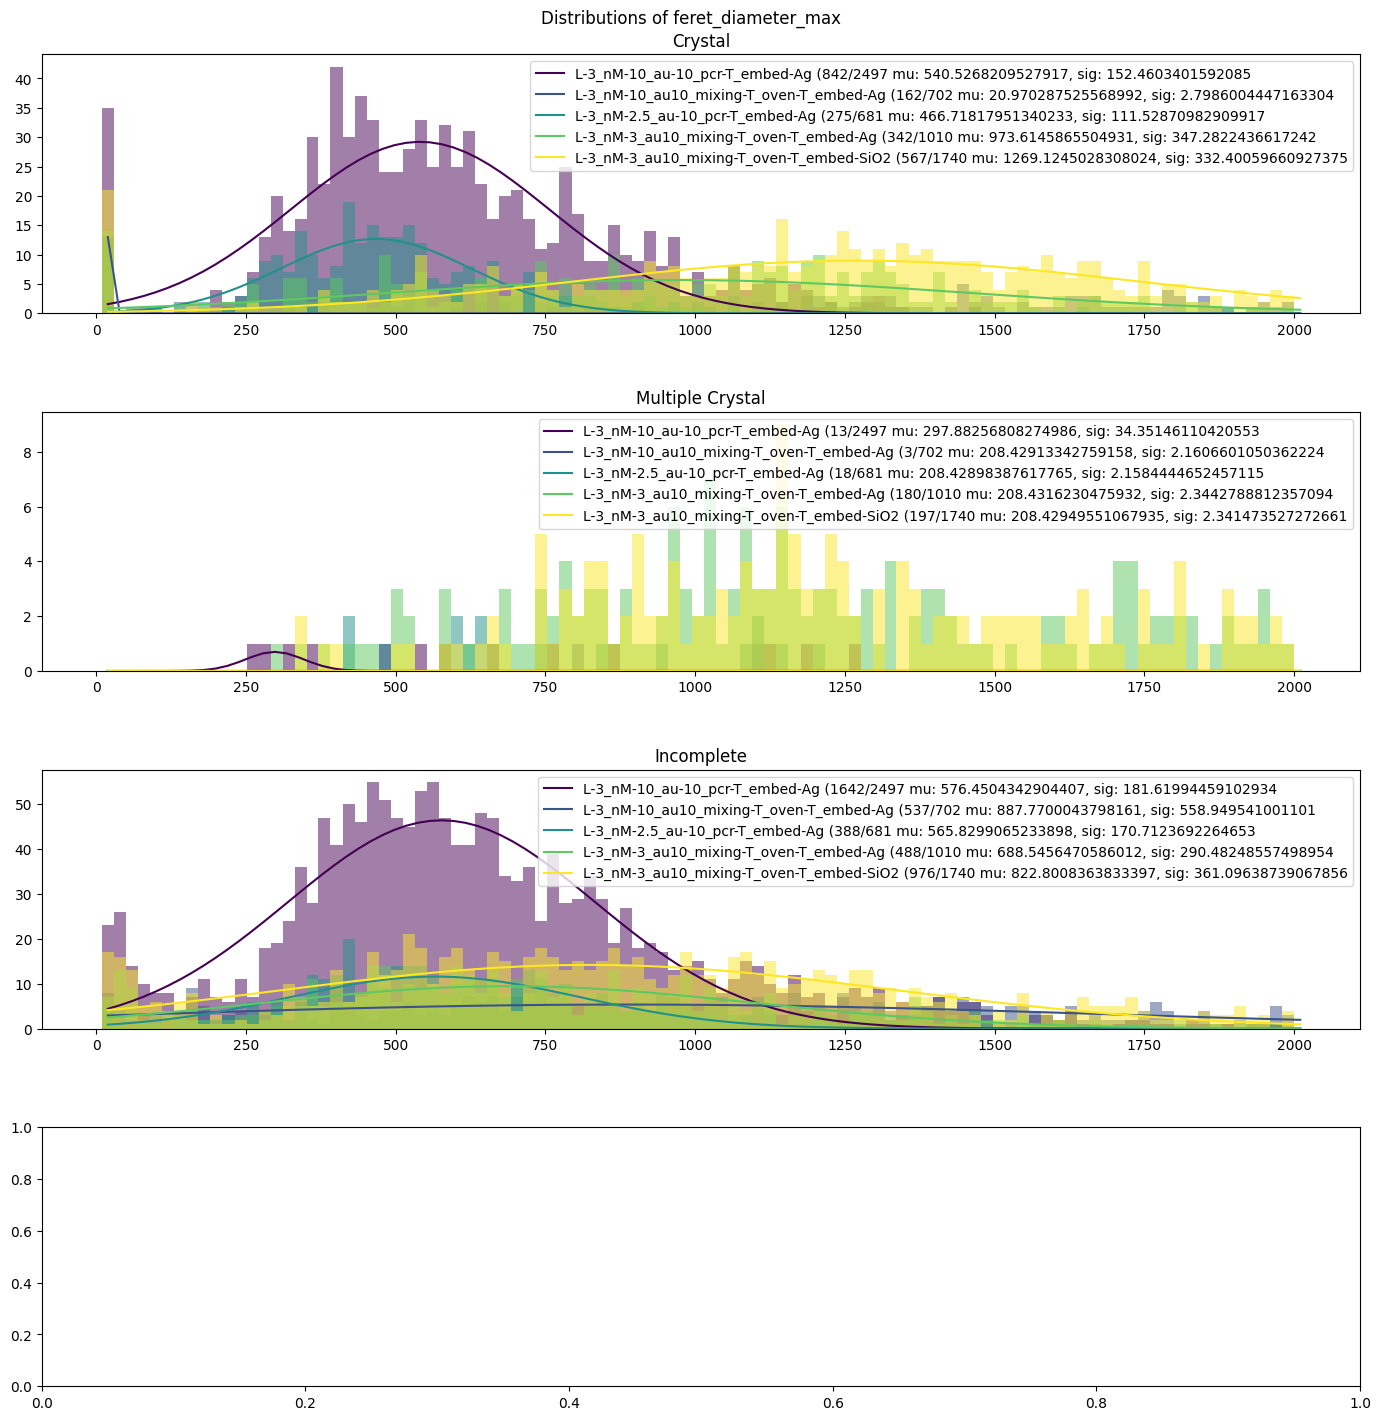

In [60]:
# Gaussian Cell
fig_gaussian = pdu.plot_feature_with_experiments_gaussian(df_master,'feret_diameter_max',exp_list,color_list=cm_arr.colors)
plt.show(fig_gaussian)



Crystal
88.0 842
Multiple Crystal
88.0 13
Incomplete
88.0 1642
Crystal
88.0 162
Multiple Crystal
88.0 3
Incomplete
88.0 537
Crystal
88.0 275
Multiple Crystal
88.0 18
Incomplete
88.0 388
Crystal
88.0 342
Multiple Crystal
88.0 180
Incomplete
88.0 488
Crystal
88.0 567
Multiple Crystal
88.0 197
Incomplete
88.0 976


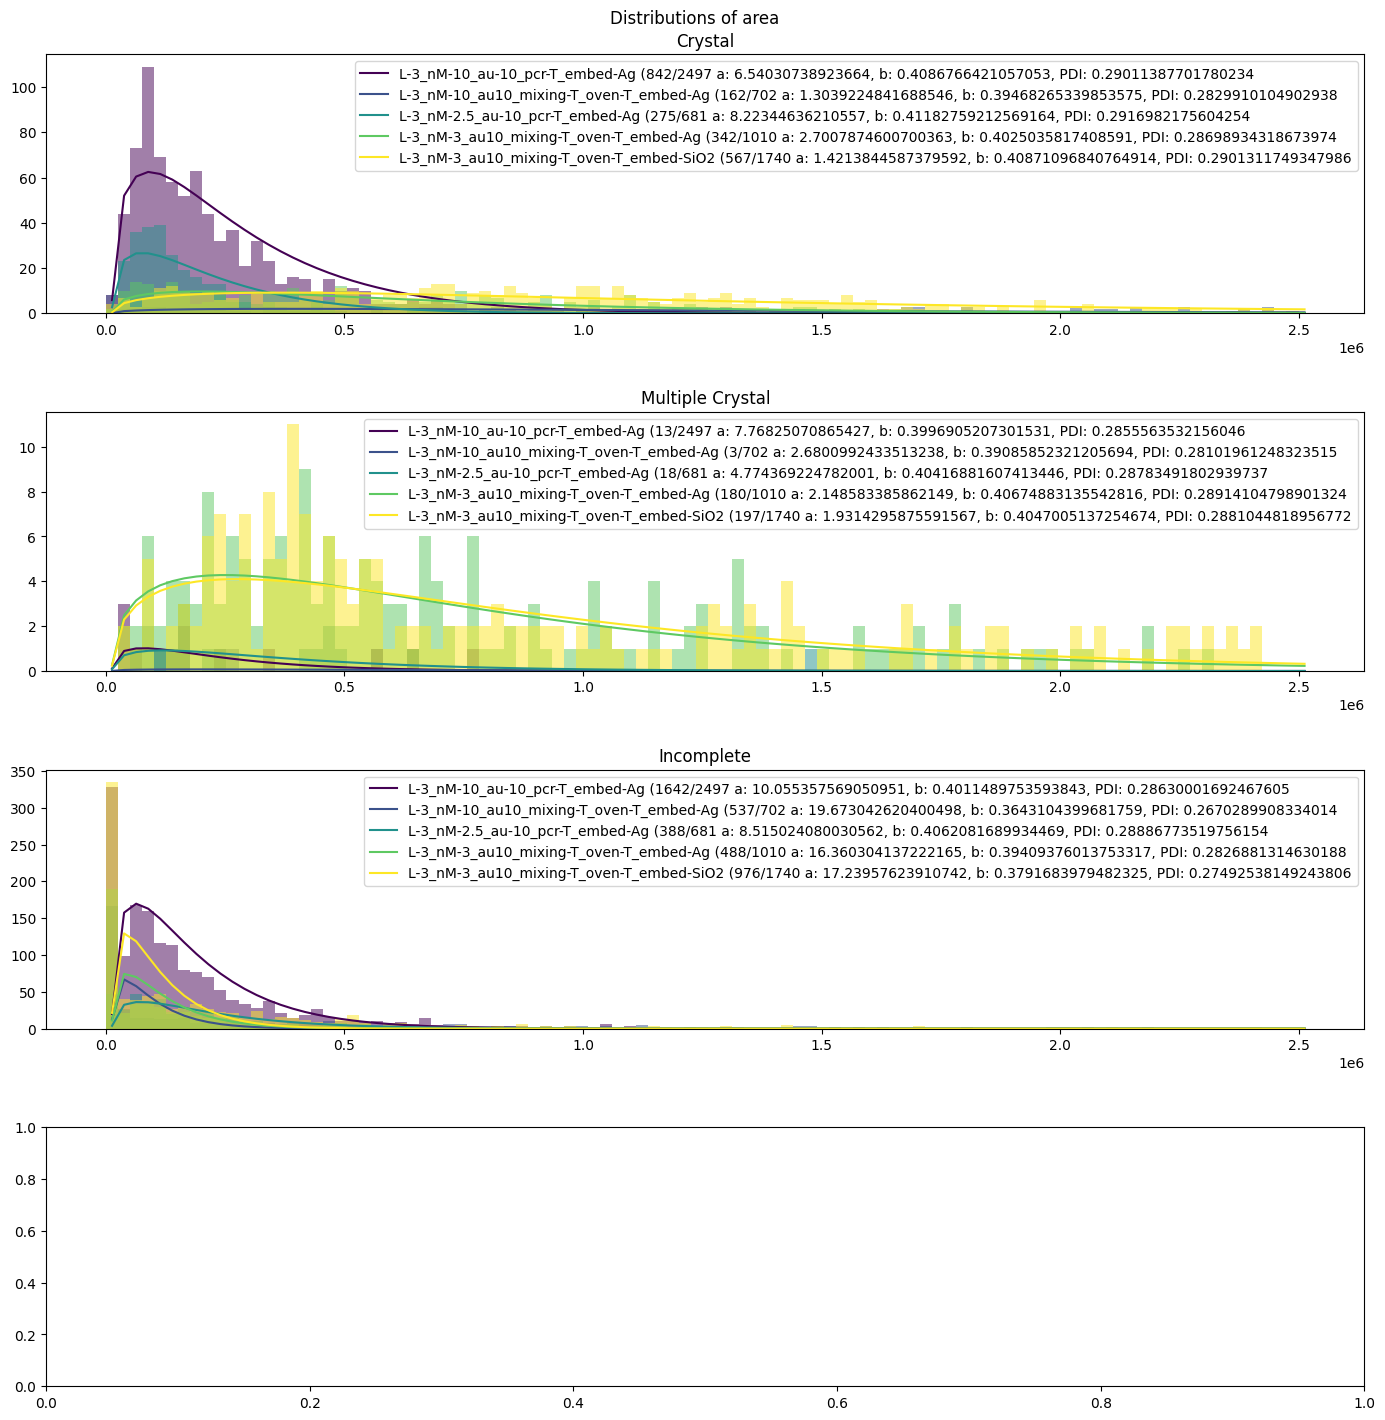

In [61]:
# Schulz Cell
fig_sz = pdu.plot_feature_with_experiments_schultz_zimm(df_master,'area',exp_list,color_list=cm_arr.colors)
plt.show(fig_sz)



In [62]:
## WIP cell for checking out what's going on with Schultz-Zimm
from scipy.optimize import curve_fit
sz = pdu.schultz_zimm
df_oi = pdu.load_dataframe(exp_list[0])
df_oi = df_oi[df_oi["Labels"] == "Crystal"]
fig_oi, ax_oi = plt.subplots()
# COPY PASTING CODE FROM pdu
feature = 'area'
max_out = 2.50*10**6 if feature == 'area' else 2000


histogram_min = df_oi[feature].min()
histogram_max = df_oi[feature].max()
histogram_bins = np.round(np.linspace(histogram_min, max_out,200))


freq = pdu.get_frequency(df_oi,histogram_bins,feature)
scale_factor = 1#counts*histogram_bins[0]
x_bins = histogram_bins #+ (histogram_bins[2]-histogram_bins[1])/2 # Fit to center of bin
prob = np.array(freq)/(np.sum(freq))
popt,pcov = curve_fit(sz,x_bins,prob,
                                  p0=[0,0,1],
                                  bounds=([0.0,0.0,0.5],[50,5,2.1]),
                                  )
a = popt[0]
b = popt[1]
molecular_weight = b/a
molecular_number = (b+1)/a
pdi = molecular_weight/molecular_number


ax_oi.plot(x_bins,sz(histogram_bins,*popt)*scale_factor/np.diff(histogram_bins)[0],color='r')

weights=df_oi[feature]/len(df_oi[feature])
ax_oi.hist(x=df_oi[feature],bins=histogram_bins,color='r',alpha=.5,density=True)
ax_oi.scatter(histogram_bins,prob/np.diff(histogram_bins)[0])

ax_oi.legend()


print(popt)
ax_oi.plot(x_bins,sz(histogram_bins,
                     *[7,.75,.5,1e4])*scale_factor/np.diff(histogram_bins)[0],
                     color='g')


FileNotFoundError: [Errno 2] No such file or directory: '../Results/L-3_nM-10_au-10_pcr-T_embed-Ag'

In [ ]:
c1 = 

SyntaxError: invalid syntax (4246105365.py, line 1)